<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%EB%8F%99%EC%A0%81%EC%9E%90%EC%82%B0%EB%B0%B0%EB%B6%84(%2B%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8)_%EC%A0%84%ED%86%B5_%EB%93%80%EC%96%BC%EB%AA%A8%EB%A9%98%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
!pip install yfinance
!pip install pandas_market_calendars

In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Markdown
import csv
import json

# 데이터 csv 내보내기 사용 여부
is_export_csv = True

# display에서 소수점 4자리까지 표현
pd.options.display.float_format = '{:.4f}'.format

# display시 DataFrame 모든 열 표시
pd.set_option('display.max_columns', None)

# 데이터 가져올 기간을 지정합니다. (오늘로부터 12개월 전)
today = datetime.today().date()
# start_date = today - timedelta(days=375)

# 오늘 날짜 string에 저장
str_today = today.strftime('### %Y-%m-%d ')

# 전략명
str_strategy = '전통 듀얼모멘텀 '

# 오늘 날짜를 가져와서 파일명에 추가
today_date = today.strftime('%y%m%d')
filename = f'{today_date} {str_strategy}.xlsx'

# csv 경로 설정
output_path =  '/content/drive/MyDrive/DynamicAssetAllocation/'

# 월평균영업일수. average Monthly Business Day
MBD = 21

# 전략에 사용할 ETF 명 리스트에 담기
etf_stock = ['SPLG', 'VEA']
etf_bond = ['AGG']
etf_canary = ['BIL']

# 자산군 리스트 더하기, 중복 제거
etf_order = list(set(etf_stock + etf_bond + etf_canary))

# ETF 가격 추출
df_etf = yf.download(etf_order, end=today)['Adj Close']\
.sort_index(ascending=False)[etf_order].rename_axis(None, axis=0).dropna()
display(df_etf)

# 1개월씩 자르기
df_etf_monthly = df_etf[::MBD]

[*********************100%%**********************]  4 of 4 completed


,SPLG,AGG,BIL,SPDW
2023-12-22,55.6900,98.8300,91.3100,33.7200
2023-12-21,55.6100,98.9600,91.3000,33.6500
2023-12-20,55.0200,98.9700,91.2400,33.1200
2023-12-19,55.8600,98.6100,91.2200,33.4600
2023-12-18,55.5300,98.4900,91.2200,33.1500
...,...,...,...,...
2007-06-05,12.8275,60.7688,78.7292,21.3772
2007-06-04,12.9114,60.9416,78.7292,21.4729
2007-06-01,12.8057,60.8676,78.7120,21.2049
2007-05-31,12.8057,60.9304,78.6949,21.3453


In [112]:
# 인덱스 만들기
df_momentum_index = ['today/' + str(df_etf.index[0].date()), '1mo_ago/' + str(df_etf.index[MBD].date()), \
                     '3mo_ago/' + str(df_etf.index[MBD*3].date()), '6mo_ago/' + str(df_etf.index[MBD*6].date()), \
                     '12mo_ago/' + str(df_etf.index[MBD*12].date())]


## DataFrame 만들기: 1-3-6-12 개월 etf 가격
price_today = df_etf.iloc[0:1]
price_1mo = df_etf.shift(-MBD).iloc[0:1]
price_3mo = df_etf.shift(-MBD*3).iloc[0:1]
price_6mo = df_etf.shift(-MBD*6).iloc[0:1]
price_12mo = df_etf.shift(-MBD*12).iloc[0:1]

df_price = pd.concat([price_today, price_1mo, price_3mo, price_6mo, price_12mo])
df_price.index = df_momentum_index

str_etf_price = str_today + str_strategy + "### ETF 현재-1-3-6-12 개월 가격"
display(Markdown(str_etf_price))
display(df_price)

# csv에 제목 및 DataFrame 추가. 드라이브 마운트 후 해야함
if is_export_csv:
  with open(output_path + filename, 'w') as f:
    f.write(f'{str_etf_price}\n')
    df_price.to_csv(f, index=True)

### 2023-12-24 전통 듀얼모멘텀 ### ETF 현재-1-3-6-12 개월 가격

,SPLG,AGG,BIL,SPDW
today/2023-12-22,55.6900,98.8300,91.3100,33.7200
1mo_ago/2023-11-22,53.2967,95.0448,90.9118,32.0012
3mo_ago/2023-09-25,50.6174,93.2253,90.1096,31.0513
6mo_ago/2023-06-26,50.3464,96.4826,88.9547,31.6153
12mo_ago/2022-12-21,44.6834,95.2451,86.9696,29.0914


In [113]:
## DataFrame 만들기: 1년 수익률
df_etf_monthly_copy = df_etf_monthly.copy(deep=True)
df_etf_ror_12mo = pd.DataFrame(index=df_etf_monthly.index, columns=df_etf_monthly.columns)

for i in range(0, len(df_etf_monthly) - 12):
  # ror_1mo = df_etf_monthly_copy.pct_change(-1).iloc[0]  # 1개월 수익률
  # ror_3mo = df_etf_monthly_copy.pct_change(-3).iloc[0]  # 3개월 수익률
  # ror_6mo = df_etf_monthly_copy.pct_change(-6).iloc[0]  # 6개월 수익률
  ror_12mo = df_etf_monthly_copy.pct_change(-12).iloc[0]  # 12개월 수익률
  df_etf_monthly_copy.drop(df_etf_monthly_copy.index[0], inplace=True)

  # 가중치 더하기
  df_etf_ror_12mo.iloc[i] = ror_12mo * 100

df_etf_ror_12mo.dropna(inplace=True)

str_etf_ror_12mo = str_today + str_strategy + "### ETF 별 12 개월 수익률"
display(Markdown(str_etf_ror_12mo))
display(df_etf_ror_12mo)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_ror_12mo}\n')
    df_etf_ror_12mo.head(5).to_csv(f, index=True)

### 2023-12-24 전통 듀얼모멘텀 ### ETF 별 12 개월 수익률

,SPLG,AGG,BIL,SPDW
2023-12-22,24.6325,3.7639,4.9908,15.9107
2023-11-22,17.2411,1.6947,4.8658,12.4437
2023-10-24,15.0823,1.8690,4.6489,15.6280
2023-09-25,17.3954,-0.3806,4.3879,19.2112
2023-08-24,7.7688,-2.7264,4.1880,9.6523
...,...,...,...,...
2008-10-16,-37.6377,-1.7343,2.3816,-43.4552
2008-09-17,-19.8686,5.5268,3.1129,-23.4485
2008-08-18,-6.6564,6.4463,2.4966,-10.0368
2008-07-18,-15.7371,5.7582,3.0765,-15.0093


In [126]:
## DataFrame 만들기: ETF 종목, 종목별 투자 비율
row_count = len(df_etf_ror_12mo)
columns_num = [i for i in range(1)]
df_high_etf = pd.DataFrame(columns=columns_num, index=df_etf_ror_12mo.index)
df_buy_ratio_etf = pd.DataFrame(columns=columns_num, index=df_etf_ror_12mo.index)

# 마지막에 출력할 str 정의
str_buy_etf = ''
str_etf_ratio = ''
str_result_etf_bool = ''
str_result_stock_sel = ''

for i in reversed(range(row_count)):
  # SPY와 EFA 둘 다 BIL 보다 1년 수익률 낮은가?
  if df_etf_ror_12mo.iloc[i][etf_stock[0]] < df_etf_ror_12mo.iloc[i][etf_canary[0]] and df_etf_ror_12mo.iloc[i][etf_stock[1]] < df_etf_ror_12mo.iloc[i][etf_canary[0]]:
    str_result_etf_bool = 'True'

    # 낮으면 AGG ETF 로 변신
    str_buy_etf = etf_bond[0]
    str_result_stock_sel = ''
    df_high_etf.iloc[i] = [etf_bond[0]]
    df_buy_ratio_etf.iloc[i] = [1]

  # SPY와 EFA 중 1년 수익률 더 높은 곳에 투자
  else:
    str_result_etf_bool = 'False'

    if df_etf_ror_12mo.iloc[i][etf_stock[0]] < df_etf_ror_12mo.iloc[i][etf_stock[1]]:
      str_result_stock_sel = etf_stock[1]
    else:
      str_result_stock_sel = etf_stock[0]

    df_high_etf.iloc[i] = str_result_stock_sel
    str_buy_etf = str_result_stock_sel
    df_buy_ratio_etf.iloc[i] = [1]

  # 최신 데이터로 종목 뽑기
  if i == 0:
    str_buy_etf = ' '.join(df_high_etf.iloc[i].drop_duplicates())
    str_etf_ratio = str(round(df_buy_ratio_etf[df_buy_ratio_etf > 0].iloc[i].drop_duplicates().dropna()[0] * 100)) + ' %'

str_high_etf = str_today + str_strategy + "### ETF 투자 종목 선정"
display(Markdown(str_high_etf))
display(df_high_etf)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_high_etf}\n')
    df_high_etf.head(5).to_csv(f, index=True)

### 2023-12-24 전통 듀얼모멘텀 ### ETF 투자 종목 선정

,0
2023-12-22,SPLG
2023-11-22,SPLG
2023-10-24,SPDW
2023-09-25,SPDW
2023-08-24,SPDW
...,...
2008-10-16,AGG
2008-09-17,AGG
2008-08-18,AGG
2008-07-18,AGG


In [115]:
# 종목별 투자 비율
df_buy_ratio = df_buy_ratio_etf

str_buy_ratio = str_today + str_strategy + "### ETF 투자 비율"
display(Markdown(str_buy_ratio))
display(df_buy_ratio)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_buy_ratio}\n')
    df_buy_ratio.head(5).to_csv(f, index=True)

### 2023-12-24 전통 듀얼모멘텀 ### ETF 투자 비율

,0
2023-12-22,1
2023-11-22,1
2023-10-24,1
2023-09-25,1
2023-08-24,1
...,...
2008-10-16,1
2008-09-17,1
2008-08-18,1
2008-07-18,1


In [116]:
## 백테스트
monthly_column_count = df_high_etf.shape[1]
monthly_index = df_high_etf.index

# 비율대로 돈 투자
df_invest_money = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_invest_count = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_cash = pd.DataFrame(columns=['cash'], index=monthly_index)

# 초기자본
invest_cash = 10_000

for i in reversed(range(row_count)):
  row_sum = 0

  for j in range(monthly_column_count):
    if i == row_count - 1:
      row_sum = invest_cash
      break
    else:
      sel_etf = df_high_etf.iloc[i+1][j]
      row_sum += df_invest_count.iloc[i+1][j] * df_etf_monthly.iloc[i][sel_etf]

  for j in range(monthly_column_count):
    df_cash.iloc[i][0] = row_sum
    sel_etf = df_high_etf.iloc[i][j]
    sel_etf_price = df_etf_monthly.iloc[i][sel_etf]
    sel_etf_buy_count = df_cash.iloc[i][0] * df_buy_ratio.iloc[i][j] / sel_etf_price
    df_invest_count.iloc[i][j] = sel_etf_buy_count

# 종목 대체 평가시 사용
# df_cash = df_cash[:108]
# row_count = len(df_cash)
display(Markdown(str_today + str_strategy + '### ETF 구매 개수'))
display(df_invest_count)
display(Markdown(str_today + str_strategy + '### 평가 금액'))
display(df_cash)

CAGR = str(round(((df_cash.iloc[0][0] / df_cash.iloc[-1][0]) ** (12/(row_count-1)) - 1)*100, 2))
display(Markdown(f'{str_today[1:]} {str_strategy} ## CAGR: {CAGR} %'))

### 2023-12-24 전통 듀얼모멘텀 ### ETF 구매 개수

,0
2023-12-22,523.9062
2023-11-22,523.9062
2023-10-24,872.5441
2023-09-25,872.5441
2023-08-24,872.5441
...,...
2008-10-16,154.3033
2008-09-17,154.3033
2008-08-18,154.3033
2008-07-18,154.3033


### 2023-12-24 전통 듀얼모멘텀 ### 평가 금액

,cash
2023-12-22,29176.3350
2023-11-22,27922.4668
2023-10-24,25910.7364
2023-09-25,27093.5974
2023-08-24,27128.1355
...,...
2015-05-21,17877.0029
2015-04-22,17673.1277
2015-03-23,17650.0821
2015-02-20,17598.6503


## 2023-12-24  전통 듀얼모멘텀  ## CAGR: 6.34 %

In [123]:
## 결과 출력
display(Markdown(str_today[1:] + str_strategy))

str_result_etf = '## SPLG 와 VEA 둘 다 BIL 보다 1년 수익률이 낮은가?: ' + str_result_etf_bool
display(Markdown(str_result_etf))

str_result_stock = '## 높으면 SPLG 와 VEA 중 더 수익률 높은 것: ' + str_result_stock_sel
display(Markdown(str_result_stock))

str_result_buy = '## 구매할 자산: ' + str_buy_etf
display(Markdown(str_result_buy))

str_result_ratio = '## 각각 구매 비율: ' + str_etf_ratio
display(Markdown(str_result_ratio))

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_today[1:] + str_strategy}\n')
    f.write(f'{str_result_etf}\n')
    f.write(f'{str_result_stock}\n')
    f.write(f'{str_result_buy}\n')
    f.write(f'{str_result_ratio}\n')

## 2023-12-24 전통 듀얼모멘텀 

## SPLG 와 VEA 둘 다 BIL 보다 1년 수익률이 낮은가?: False

## 높으면 SPLG 와 VEA 중 더 수익률 높은 것: SPLG

## 구매할 자산: SPLG

## 각각 구매 비율: 100 %

<Axes: >

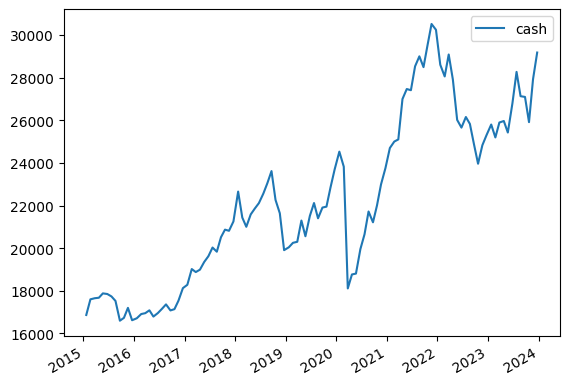

In [118]:
df_cash.plot()